In [1]:
import networkx as nx
import random
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from matplotlib.ticker import ScalarFormatter

# the function to do simulations

## to compute fixation probabilities (without mutation)

### funtion

In [2]:
def fixation_probabilities(G, N, beta_set, b, c):
    '''
    G: network structure of an evolutionary game
    N: population size
    beta_set: selection strength
    b: the benifit of altruistic behavior
    c: the cost of altruistic behavior
    '''
    ##### distribute strategies to each node #####
    # 1 represents cooperator(C)
    # 2 represents defector(D)
    ##############################################
    
    # make the strategies of all nodes D
    node_strategies = {}
    for node in G.nodes():
        strategy = random.choice(['2', '2'])
        node_strategies[node] = strategy
    selected_coop_node = random.choice(list(G.nodes()))
    node_strategies[selected_coop_node] = '1'
    
    # initializes the number of nodes for each strategy
    n = N
    coop_count = sum(1 for node in G.nodes() if  node_strategies[node] == '1')
    defe_count = n - coop_count
    
    # set counter
    update_round = 0
    cal1 = 0
    cal2 = 0
    
    # 100,000 simulations will run, each ending with a fixed population
    while update_round < 100000:
        node_strategies1 = node_strategies.copy()
        coop_count1 = coop_count
        defe_count1 = defe_count
        
        # updating
        while True:
            if coop_count1 == 0 or defe_count1 == 0:
                break  # if all nodes become C nodes or all nodes become D nodes, the update stops
            else:
                # select a node randomly
                selected_node = random.choice(list(G.nodes()))
                # calculate the fitness of all neighbors of the focal point
                sumC = 0
                sumD = 0
                for neighbor in G.neighbors(selected_node):
                    # find the distribution of neighbors of neighbors
                    CC = 0
                    DD = 0
                    for neighbor_neighbor in G.neighbors(neighbor):
                        if node_strategies1[neighbor_neighbor] == '1':
                            CC += 1
                        else:
                            DD += 1
                    # calculate the fitness of neighbors
                    beta = beta_set
                    if node_strategies1[neighbor] == '1':
                        sumC += math.exp(beta*((b-c)*CC + (-c)*DD))
                    else:
                        sumD += math.exp(beta*(b*CC))
                
                # the probability of change
                pcd = sumD / (sumC + sumD)
                pdc = sumC / (sumC + sumD)
                
                ########## update the selected node ##########
                
                if node_strategies1[selected_node] == '1':    # original strategy is C
                    update_prob_1 = random.uniform(0, 1)
                    if update_prob_1 < pcd:                   # change to D
                        node_strategies1[selected_node] = '2'
                        coop_count1 -= 1
                        defe_count1 += 1
                    else:
                        node_strategies1[selected_node] = '1'
                else:                                         # original strategy is D
                    update_prob_2 = random.uniform(0, 1)
                    if update_prob_2 < pdc:                   # change to C
                        node_strategies1[selected_node] = '1'
                        coop_count1 += 1
                        defe_count1 -= 1
                    else:
                        node_strategies1[selected_node] = '2'

        update_round += 1 
        
        if coop_count1 == 0:
            cal2 += 1          # All nodes become D nodes
        elif defe_count1 == 0:
            cal1 += 1          # All nodes become C nodes
    
    # compute the fixation probability
    ratio = cal1 / update_round if update_round != 0 else cal1  # 计算两个数量之比
    
    # print the result
    print("fixation probability = ", ratio)

### example
$G → lattice$, $N = 100$, $\beta = 0.001$, $b = 4$, $c = 1$

The theoretical result is the fixation probability $\rho = 1/N =0.01$

In [56]:
G1 = nx.grid_2d_graph(10, 10)

In [59]:
fixation_probabilities(G1, 100, 0.001, 4, 1)

fixation probability =  0.01089


In [61]:
fixation_probabilities(G1, 100, 0.001, 4, 1)

fixation probability =  0.01064


In [61]:
fixation_probabilities(G1, 100, 0.001, 4, 1)

fixation probability =  0.01064


In [61]:
fixation_probabilities(G1, 100, 0.001, 4, 1)

fixation probability =  0.01064


## to compute long-term drequencies (have mutation)

### function

In [48]:
def long_term_abundance(G, N, beta_set, b, c):
    '''
    G: network structure of an evolutionary game
    N: population size
    beta_set: selection strength
    b: the benifit of altruistic behavior
    c: the cost of altruistic behavior
    '''
    ##### distribute strategies to each node #####
    # 1 represents C
    # 2 represents D
    ##############################################
    
    # make the strategies of all nodes C
    node_strategies = {}
    for node in G.nodes():
        strategy = random.choice(['1', '1'])
        node_strategies[node] = strategy
    
    # initializes the number of nodes for each strategy
    n = N
    C_count = sum(1 for node in G.nodes() if  node_strategies[node] == '1')
    D_count = n - C_count
    
    node_strategies1 = node_strategies.copy()
    C_count1 = C_count
    D_count1 = D_count
    
    # set counter
    update_round = 0
    cal1 = 0
    cal2 = 0
    C_round = [0]*10000000
    D_round = [0]*10000000
    
    # update 10000000 rounds
    while update_round < 10000000:
        # select a node randomly
        selected_node = random.choice(list(G.nodes()))
        # calculate the fitness of all neighbors of the focal point
        sum_C = 0
        sum_D = 0
        for neighbor in G.neighbors(selected_node):
            # find the distribution of neighbors of neighbors
            neighbor_C = 0
            neighbor_D = 0
            for neighbor_neighbor in G.neighbors(neighbor):
                if node_strategies1[neighbor_neighbor] == '1':
                    neighbor_C += 1
                else:
                    neighbor_D += 1
                
                # calculate the fitness of neighbors
                beta = beta_set
                if node_strategies1[neighbor] == '1':
                    sum_C += math.exp(beta*((b-c)*neighbor_C + (-c)*neighbor_D))
                else:
                    sum_D += math.exp(beta*(b*neighbor_C))
        
        # the probability of change if the selected node does not mutate
        pcd = sum_D / (sum_C + sum_D)
        pdc = sum_C / (sum_C + sum_D)
        
        ########## update the selected node ##########
        
        # mutation rate
        mutation_rate=0.0005
        
        if random.uniform(0, 1) < mutation_rate: # do mutate
            change_strategy = random.choice(['1', '2']) # randomly select a strategy to mutate
            
            if node_strategies1[selected_node] == '1':               # original strategy is C
                if change_strategy == '1':                           # mutate to C
                    node_strategies1[selected_node] = change_strategy
                else:                                                 # mutate to D
                    node_strategies1[selected_node] = change_strategy
                    C_count1 -= 1
                    D_count1 += 1
                    
            else:                                                    # original strategy is D
                if change_strategy == '1':                           # mutate to C
                    node_strategies1[selected_node] = change_strategy
                    D_count1 -= 1
                    C_count1 += 1
                else:                                                # mutate to D
                    node_strategies1[selected_node] = change_strategy
                    
        else:            # do not mutate
            if node_strategies1[selected_node] == '1':    # original strategy is C
                update_prob_1 = random.uniform(0, 1)
                if update_prob_1 < pcd:                   # change to D
                    node_strategies1[selected_node] = '2'
                    C_count1 -= 1
                    D_count1 += 1
                else:                                     # do not change
                    node_strategies1[selected_node] = '1'
                    
            else:                                         # original strategy is D
                update_prob_2 = random.uniform(0, 1)
                if update_prob_2 < pdc:                   # change to C
                    node_strategies1[selected_node] = '1'
                    D_count1 -= 1
                    C_count1 += 1
                else:                                     # do not change
                    node_strategies1[selected_node] = '2'
                    
        # record the population structure for each round
        C_round[update_round] = C_count1 / (C_count1 + D_count1)
        D_round[update_round] = D_count1 / (C_count1 + D_count1)
        
        update_round += 1
        cal1 += C_count1
        cal2 += D_count1

    # the result of long-term abundances
    fre_1 = cal1 / (cal1 + cal2) # long-term abundance of C
    fre_2 = cal2 / (cal1 + cal2) # long-term abundance of D
    
    # print the result
    #print("the long-term abundance of C = ", fre_1)
    #print("the long-term abundance of D = ", fre_2)

    # return the result (long-term abundance and population structure)
    return fre_1, fre_2, C_round, D_round

# simulation results of fixation probabilities

## painting function
Due to the peculiarity of cycles ($k = 2$) and the results of scale-free network (it can restrain cooperation), we will set up three paiting functions, "fp_paint_1()" is for the cycle; "fp_paint_2()" is for lattice, random regular graph, random graph and small-world network; "fp_paint_3()" is for the scale-free network.

In [19]:
def fp_paint_1(p, beta):
    '''
    p: the array of simulation results of fixation probabilities of C with different b/c
    '''
    # the size of figure
    plt.figure(figsize=(12, 6))
    
    # scatter plots
    z = [1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]
    
    plt.scatter(z, p, s=100, marker='^', edgecolors='#77CCE0', facecolors='#77CCE0')
    
    # 1/N
    plt.axhline(y=0.01, color='black', linestyle='--',linewidth=2)
    
    # domain of definition
    x = np.linspace(0, 10, 1000)
    
    # fixation probability of C
    if beta == 0.01:
        y = 1/100 + (1/100)*(x - 2)
        plt.plot(x, y, color='#6D8BC3', linewidth=2)
        plt.xlim(0.75, 3.25)
        plt.ylim(0, 0.02)
        # add an arrow to indicate theoretical results
        plt.annotate('',
                     xy=(2, 0.01), xycoords='data',
                     xytext=(1.87, 0.012), textcoords='data',
                     arrowprops=dict(edgecolor='#45CAFF', facecolor='#45CAFF', shrink=0.05))
    else:
        y = 1/100 + (1/1000)*(x - 2)
        plt.plot(x, y, color='#6D8BC3', linewidth=2)
        plt.xlim(0.75, 3.25)
        plt.ylim(0.0075, 0.0125)
        # add an arrow to indicate theoretical results
        plt.annotate('',
                     xy=(2, 0.01), xycoords='data',
                     xytext=(1.87, 0.0105), textcoords='data',
                     arrowprops=dict(edgecolor='#45CAFF', facecolor='#45CAFF', shrink=0.01))
    
    # Add titles and labels
    #plt.title(r'Fixation Probabilities of Cooperator', fontsize=14)
    plt.xlabel(r'Benefit-to-Cost Ratio $b/c$', fontsize=12)
    plt.ylabel(r'Fixation Probability $\rho$', fontsize=12)
    
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='lightgrey')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgrey')
    plt.tick_params(axis='both', which='major', labelsize=10)

    # save the figure
    #plt.savefig('Fixation Probabilities of Cooperator.svg',format='svg')
    
    plt.show()

In [20]:
def fp_paint_2(p, beta):
    '''
    p: the array of simulation results of fixation probabilities of C with different b/c
    '''
    # the size of figure
    plt.figure(figsize=(12, 6))
    
    # scatter plots
    z = [3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5]
    
    plt.scatter(z, p, s=100, marker='^', edgecolors='#77CCE0', facecolors='#77CCE0')
    
    # 1/N
    plt.axhline(y = 0.01, color='black', linestyle='--',linewidth=2)
    
    # domain of definition
    x = np.linspace(0, 10, 1000)
    
    # fixation probability of C
    if beta ==0.01:
        y = 1/100 + (4/600)*(x - 4)
        plt.plot(x, y, color='#6D8BC3', linewidth=2)
        plt.xlim(2.5, 5.5)
        plt.ylim(0, 0.02)
        # add an arrow to indicate theoretical results
        plt.annotate('',
                     xy=(4, 0.01), xycoords='data',
                     xytext=(3.87, 0.012), textcoords='data',
                     arrowprops=dict(edgecolor='#45CAFF', facecolor='#45CAFF', shrink=0.05))
    else:
        y = 1/100 + (4/6000)*(x - 4)
        plt.plot(x, y, color='#6D8BC3', linewidth=2)
        plt.xlim(2.5, 5.5)
        plt.ylim(0.008, 0.012)
        # add an arrow to indicate theoretical results
        plt.annotate('',
                     xy=(4, 0.01), xycoords='data',
                     xytext=(3.87, 0.0105), textcoords='data',
                     arrowprops=dict(edgecolor='#45CAFF', facecolor='#45CAFF', shrink=0.05))
    
    # Add titles and labels
    #plt.title(r'Fixation Probabilities of Cooperator', fontsize=14)
    plt.xlabel(r'Benefit-to-Cost Ratio $b/c$', fontsize=12)
    plt.ylabel(r'Fixation Probability $\rho$', fontsize=12)
    
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='lightgrey')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgrey')
    plt.tick_params(axis='both', which='major', labelsize=10)

    # save the figure
    #plt.savefig('Fixation Probabilities of Cooperator.svg',format='svg')
    
    plt.show()

In [33]:
def fp_paint_3(p, beta):
    '''
    p: the array of simulation results of fixation probabilities of C with different b/c
    '''
    # the size of figure
    plt.figure(figsize=(12, 6))
    
    # scatter plots
    z = [3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5]
    
    plt.scatter(z, p, s=100, marker='^', edgecolors='#77CCE0', facecolors='#77CCE0')
    
    # 1/N
    plt.axhline(y = 0.01, color='black', linestyle='--',linewidth=2)
    
    # domain of definition
    x = np.linspace(0, 10, 1000)
    
    # fixation probability of C
    if beta ==0.01:
        y = 1/100 + (4/600)*(x - 4)
        plt.plot(x, y, color='#6D8BC3', linewidth=2)
        plt.xlim(2.5, 5.5)
        plt.ylim(0, 0.02)
        # add an arrow to indicate theoretical results
        plt.annotate('',
                     xy=(4, 0.01), xycoords='data',
                     xytext=(3.87, 0.012), textcoords='data',
                     arrowprops=dict(edgecolor='#45CAFF', facecolor='#45CAFF', shrink=0.05))
    else:
        y = 1/100 + (4/6000)*(x - 4)
        plt.plot(x, y, color='#6D8BC3', linewidth=2)
        plt.xlim(2.5, 5.5)
        plt.ylim(0.002, 0.012)
        # add an arrow to indicate theoretical results
        plt.annotate('',
                     xy=(4, 0.01), xycoords='data',
                     xytext=(3.87, 0.0105), textcoords='data',
                     arrowprops=dict(edgecolor='#45CAFF', facecolor='#45CAFF', shrink=0.05))
    
    # Add titles and labels
    #plt.title(r'Fixation Probabilities of Cooperator', fontsize=14)
    plt.xlabel(r'Benefit-to-Cost Ratio $b/c$', fontsize=12)
    plt.ylabel(r'Fixation Probability $\rho$', fontsize=12)
    
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='lightgrey')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgrey')
    plt.tick_params(axis='both', which='major', labelsize=10)

    # save the figure
    #plt.savefig('Fixation Probabilities of Cooperator.svg',format='svg')
    
    plt.show()

## results
We set $N = 100$, and for cycle $k = 2$, for other network structures $k = 4$; for all network structures $\beta = 0.01$ or $\beta = 0.001$

Using the simulation function "fixation_probabilities()" above, we get the result arrays. The results are in the file "Data_2.xlsx"

In [17]:
# cycle
p_11 = [0.00554, 0.00701, 0.00769, 0.00885, 0.00995, 0.01105, 0.01168, 0.01469, 0.01516] # beta = 0.01
p_12 = [0.00904, 0.00947, 0.00966, 0.00968, 0.00993, 0.01043, 0.01062, 0.01064, 0.01080] # beta = 0.001

# lattice
p_21 = [0.00552, 0.00433, 0.00831, 0.01045, 0.01146, 0.01225, 0.01373, 0.01474, 0.01255] # beta = 0.01
p_22 = [0.00928, 0.00951, 0.00945, 0.00991, 0.01005, 0.01039, 0.01037, 0.01076, 0.01064] # beta = 0.001

# random regular graph
p_31 = [0.00539, 0.00659, 0.00686, 0.00810, 0.00901, 0.01047, 0.01102, 0.01244, 0.01369] # beta = 0.01
p_32 = [0.00957, 0.00973, 0.00966, 0.00978, 0.01010, 0.01022, 0.01020, 0.01049, 0.01043] # beta = 0.001

# random graph
p_41 = [0.00545, 0.00693, 0.00695, 0.00901, 0.01012, 0.01125, 0.01067, 0.01382, 0.01347] # beta = 0.01
p_42 = [0.00915, 0.00909, 0.00929, 0.00977, 0.01014, 0.01054, 0.01030, 0.01067, 0.01101] # beta = 0.001

# small-world network
p_51 = [0.00517, 0.00754, 0.00850, 0.00772, 0.01101, 0.01211, 0.01304, 0.01179, 0.01255] # beta = 0.01
p_52 = [0.00898, 0.00902, 0.00916, 0.00935, 0.00982, 0.01009, 0.01023, 0.01064, 0.01028] # beta = 0.001

# scale-free network
p_61 = [0.00041, 0.00041, 0.00047, 0.00026, 0.00160, 0.00133, 0.00057, 0.00079, 0.00132] # beta = 0.01
p_62 = [0.00277, 0.00394, 0.00377, 0.00433, 0.00452, 0.00579, 0.00608, 0.00619, 0.00623] # beta = 0.001

### Cycle

$\beta = 0.01$

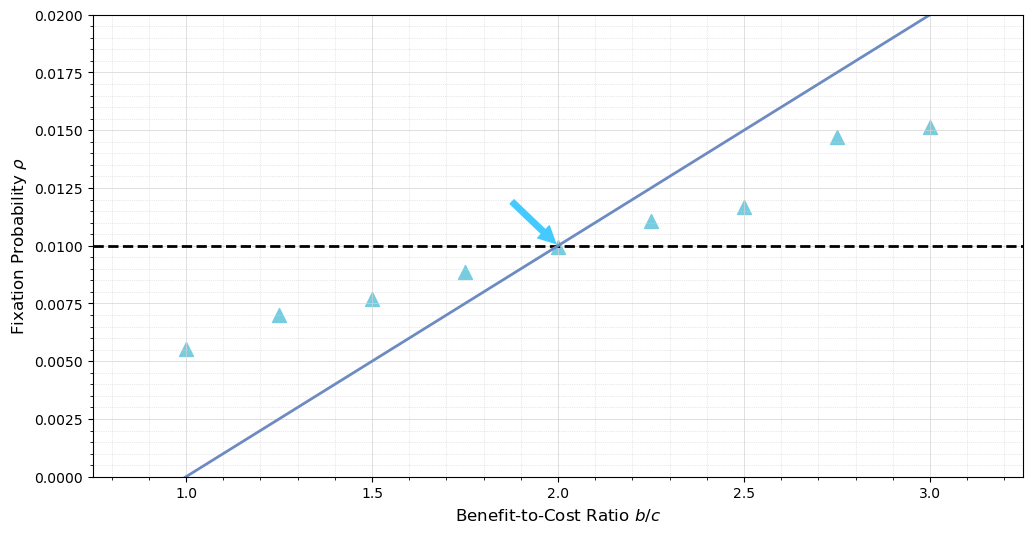

In [21]:
fp_paint_1(p_11, 0.01)

$\beta = 0.001$

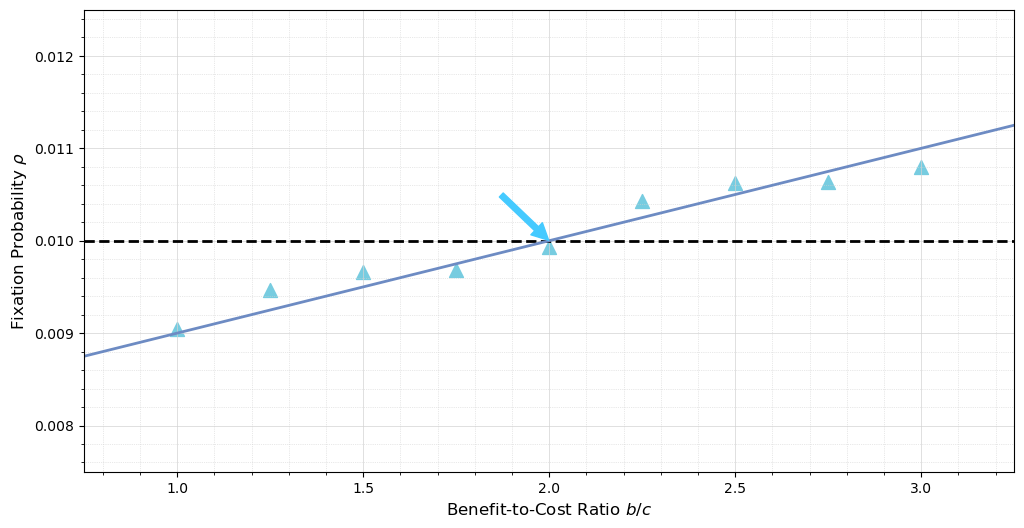

In [22]:
fp_paint_1(p_12, 0.001)

### Lattice

$\beta = 0.01$

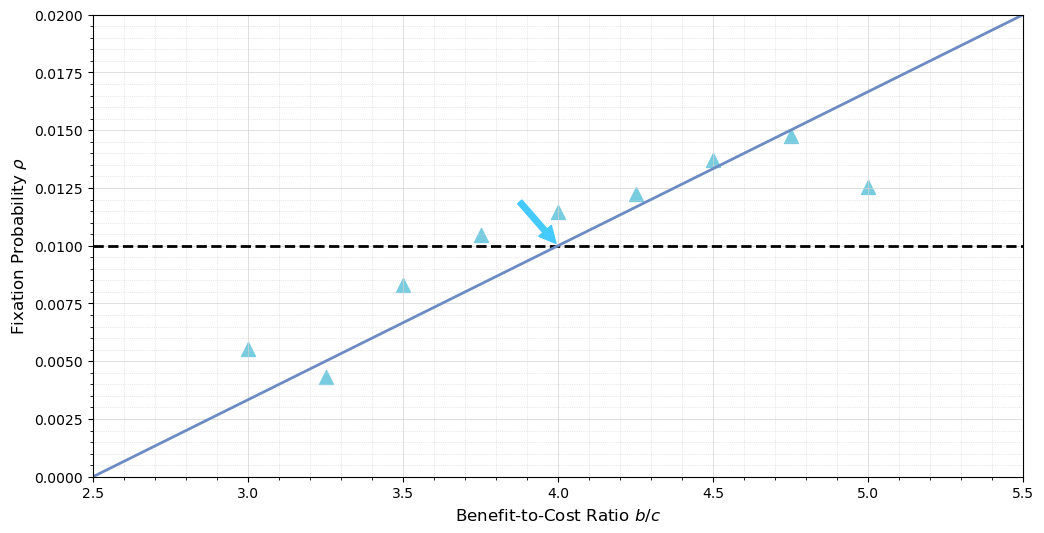

In [23]:
fp_paint_2(p_21, 0.01)

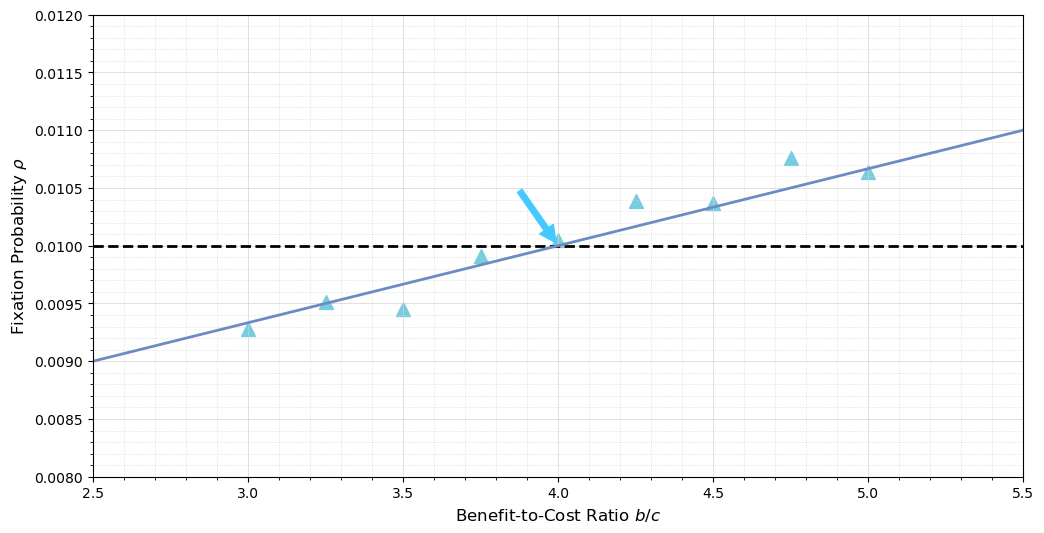

In [24]:
fp_paint_2(p_22, 0.001)

### Random regular graph

$\beta = 0.01$

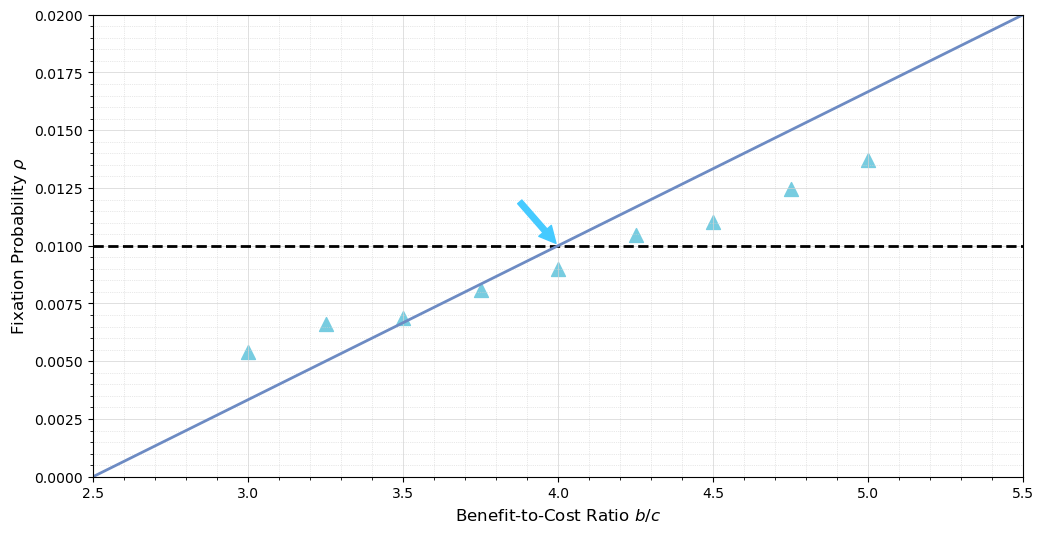

In [25]:
fp_paint_2(p_31, 0.01)

$\beta = 0.001$

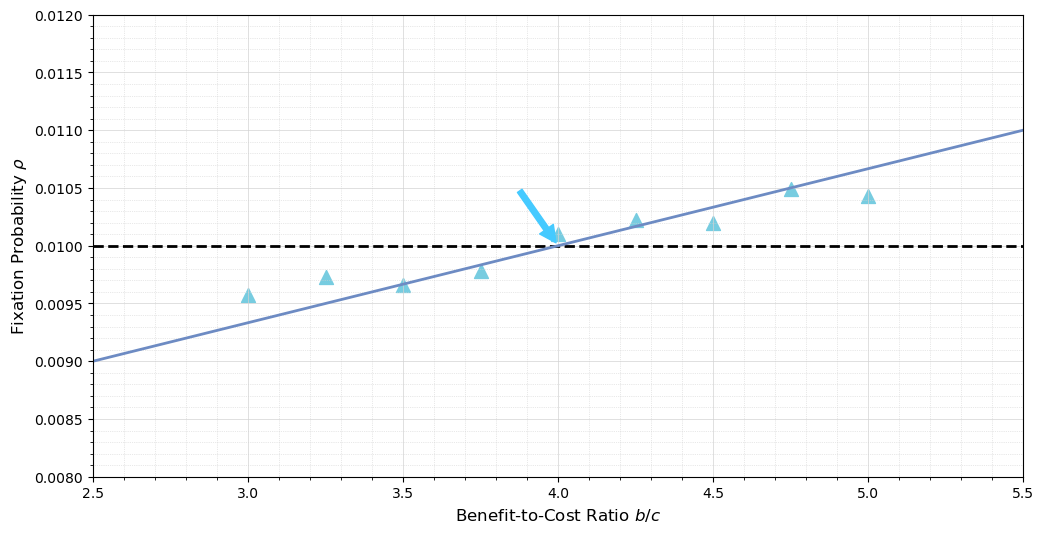

In [26]:
fp_paint_2(p_32, 0.001)

### Random graph

$\beta = 0.01$

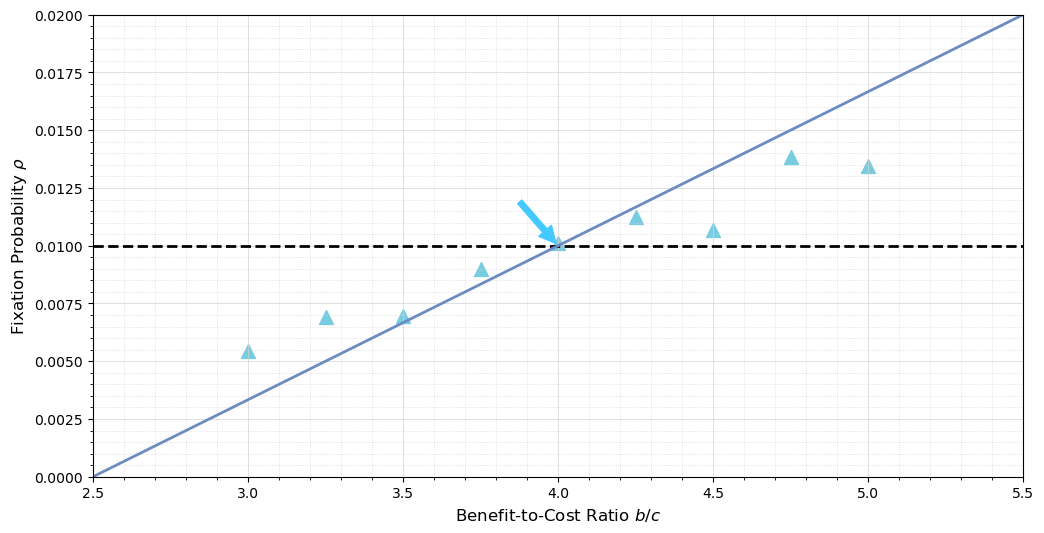

In [27]:
fp_paint_2(p_41, 0.01)

$\beta = 0.001$

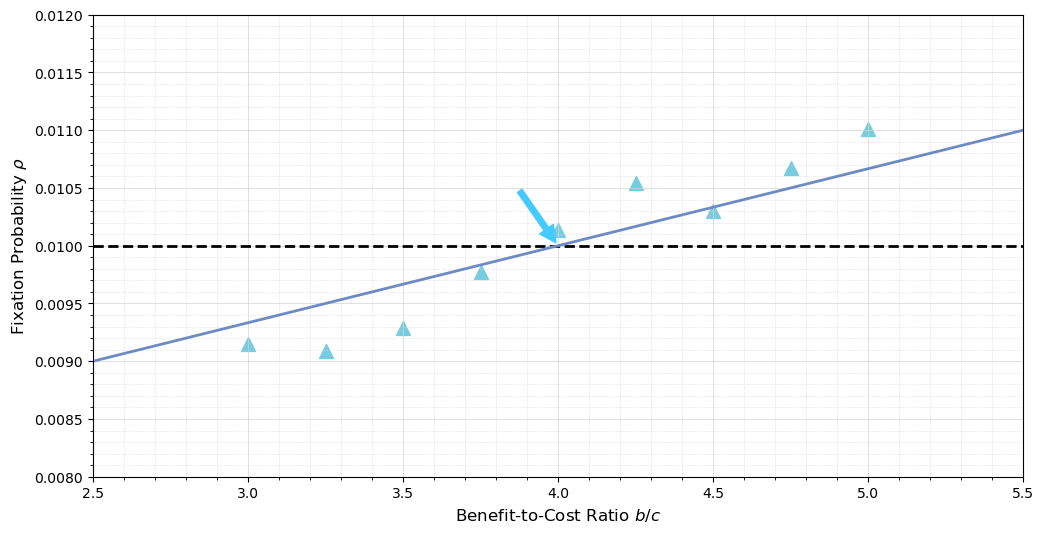

In [28]:
fp_paint_2(p_42, 0.001)

### small-world network

$\beta = 0.01$

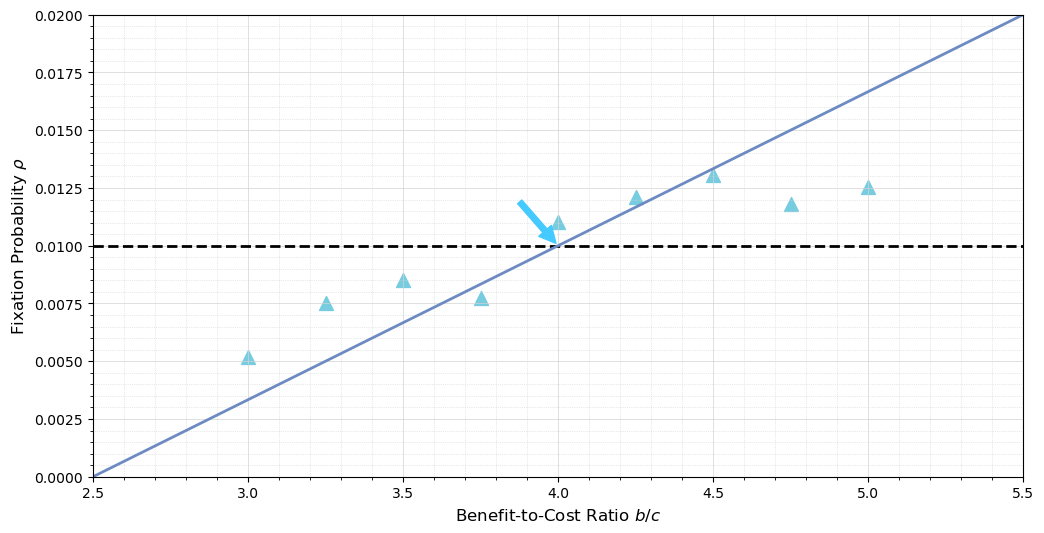

In [29]:
fp_paint_2(p_51, 0.01)

$\beta = 0.001$

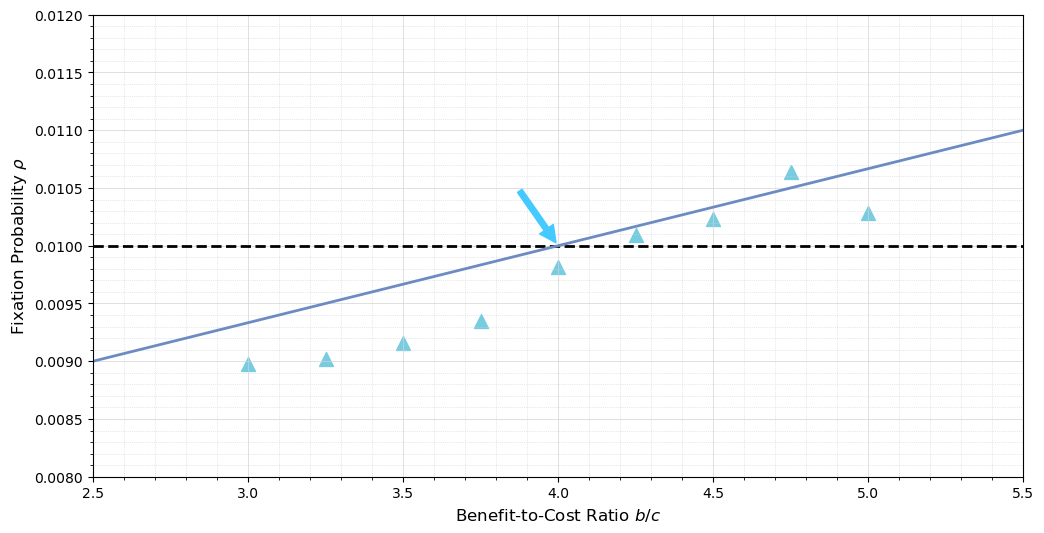

In [30]:
fp_paint_2(p_52, 0.001)

### Scale-free network
Scale-free network can restrain cooperative behavior and lead to lower results.

$\beta = 0.01$

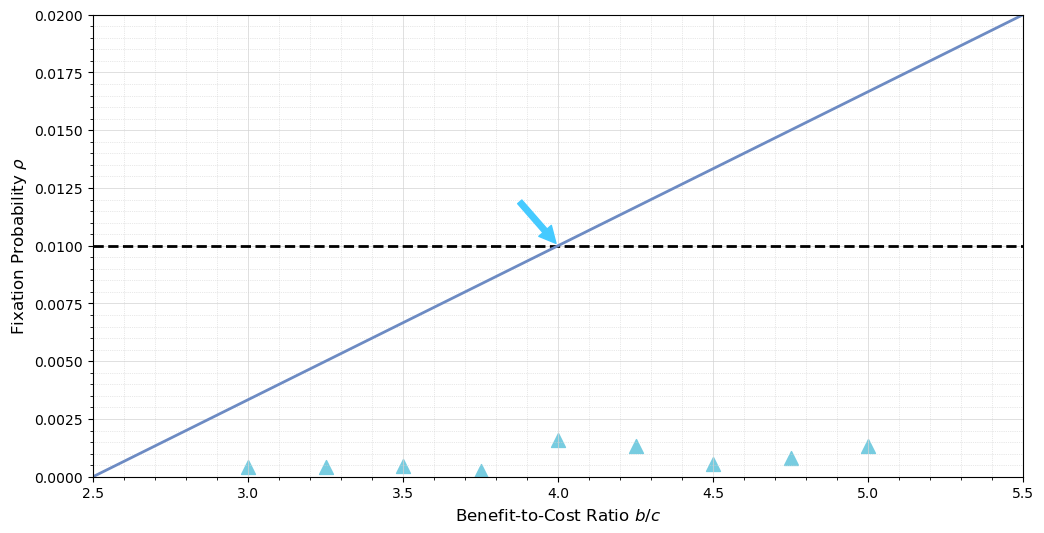

In [34]:
fp_paint_3(p_61, 0.01)

$\beta = 0.001$

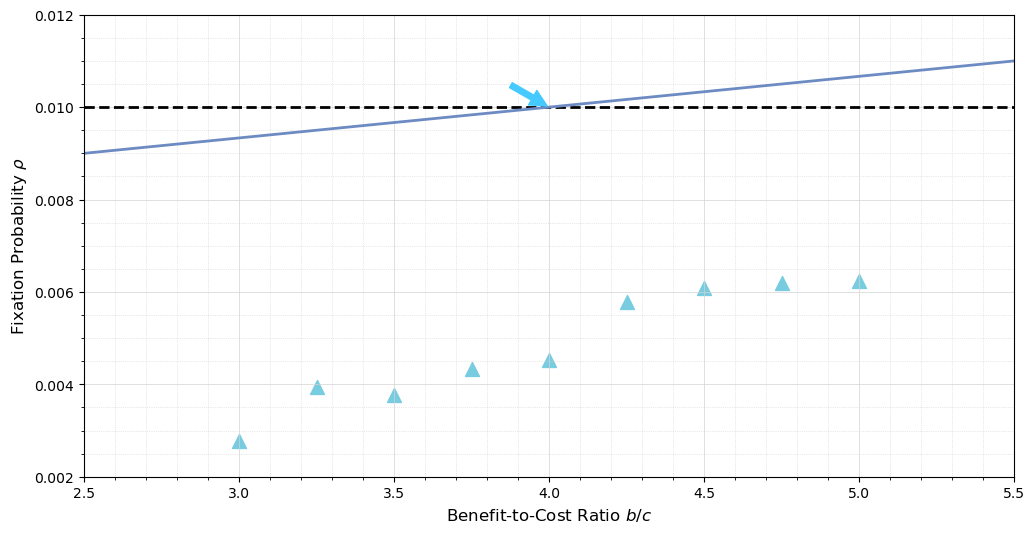

In [35]:
fp_paint_3(p_62, 0.001)

# simulation results of long-term abundances

## painting function

In [46]:
def lf_paint(fre_1, fre_2, C_round, D_round):
    '''
    fre_1: long-term abundance of Cooperator
    fre_2: long-term abundance of Defector
    C_round: the population structure of Cooperator for each round
    D_round: the population structure of Defector for each round
    '''
    t = range(10000000)
    
    population_by_continent = {
        'Cooperator           ${:.6f}$'.format(fre_1): C_round,
        'Defector               ${:.6f}$'.format(fre_2): D_round,
    }
    
    fig, ax = plt.subplots()
    
    # size of figure
    fig.set_size_inches(10, 4)
    
    colors = ['#6D8BC3', '#E9B6BE']
    ax.stackplot(t, population_by_continent.values(),
                 labels=population_by_continent.keys(),
                 colors=colors,
                 alpha=0.5)
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    ax.legend(loc='upper left')
    
    for text in ax.get_legend().get_texts():
        text.set_ha('left')
    
    ax.set_title(r'Population Structure of a doantion game')
    ax.set_xlabel(r'Time $t$')
    ax.set_ylabel('Abundance')
    
    # save the figure
    #plt.savefig('Population Structure of a doantion game on Lattice.png', format='png', dpi = 900)
    
    plt.show()


## results
The parameter settings are the same as when computing the fixation probabilities.

In the following part, lattice is taken as an example to generate results, and the results of other network structures are generated in the same way.

### example
$G → lattice$, $N = 100$, $\beta = 0.001$, $b = 4$, $c = 1$

The theoretical result is the long-term abundances of cooperator and defector $\lambda_{C} = \lambda_{D} = 0.5$.

In [38]:
G2 = nx.grid_2d_graph(10, 10)

In [51]:
lambda_C, lambda_D, C_round_1, D_round_1 = long_term_abundance(G2, 100, 0.001, 4, 1)

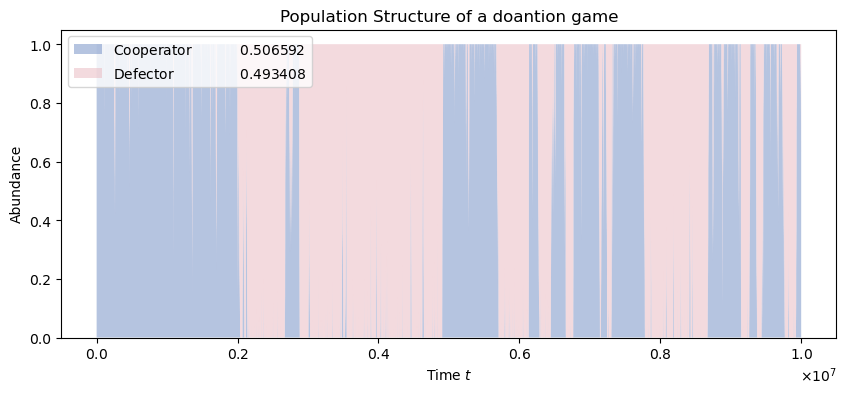

In [55]:
lf_paint(lambda_C, lambda_D, C_round_1, D_round_1)